<a href="https://colab.research.google.com/github/evacragnolino/Data-Science-Foundations/blob/main/Eva_C_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

In [3]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [21]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10,
                      dims = "aa")
    nu =pm.Exponential('nu', lam = 1/30)

    #likelihood; same as before
    cs_data['diff_TminusE'] = cs_data['theo'] - cs_data['exp'] # Calculate the difference
    y = pm.StudentT('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                    nu = nu,
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

TypeError: StudentT.dist() missing 1 required positional argument: 'nu'

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [29]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model)

Inference data with groups:
	>

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [6]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'


In [7]:
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [8]:
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
   μ_p = pm.Beta('μ_p', mu = .5, nu = 1, dims="pos")

   ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")


   θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

   _ = pm.Binomial('gs',
                        n = sccr_data.shots.values, #shots for each player
                        p = θ, #guess of goals per shot
                        observed = sccr_data.goals.values) #goals per player
   idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In [23]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.003 0.9995 ... 1.001 0.9996 1.002
    μ_p      (pos) float64 32B 1.0 0.9996 1.119 1.0
    ν_p      (pos) float64 32B 1.022 1.011 1.086 1.003

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

foward

<Axes: title={'center': 'μ_p'}>

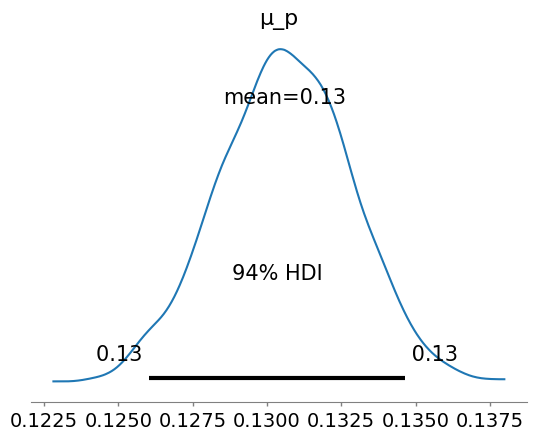

In [25]:
az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p')

Midfielder

<Axes: title={'center': 'μ_p'}>

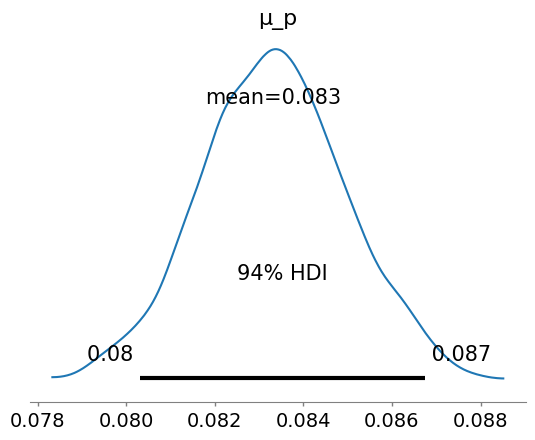

In [28]:
az.plot_posterior(idata_sccr.posterior.sel(pos="MF"), var_names='μ_p')

defensive

<Axes: title={'center': 'μ_p'}>

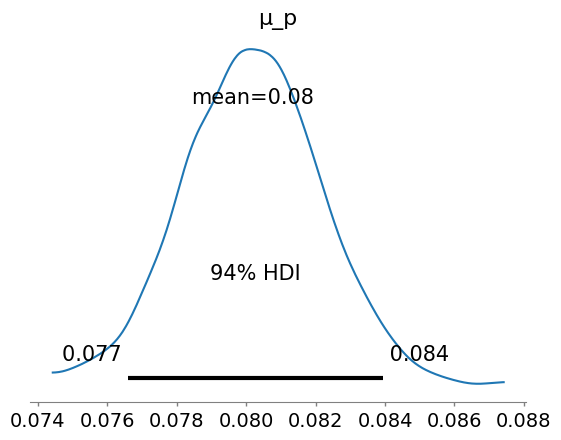

In [27]:
az.plot_posterior(idata_sccr.posterior.sel(pos="DF"), var_names='μ_p')

Goal Keeper

<Axes: title={'center': 'μ_p'}>

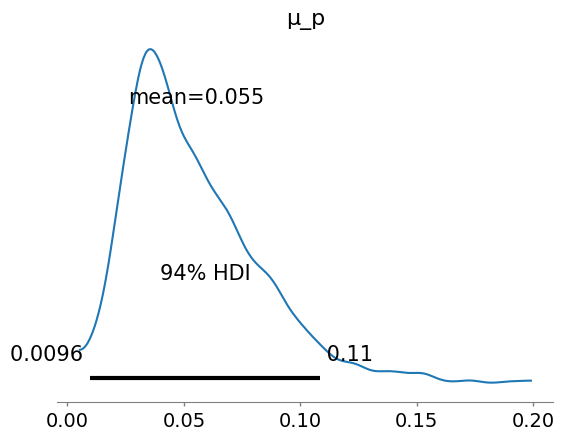

In [26]:
az.plot_posterior(idata_sccr.posterior.sel(pos="GK"), var_names='μ_p')

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [30]:
sccr_data = pd.read_csv(url_sccr)

In [31]:
sccr_data = sccr_data[sccr_data.position != 'GK']

In [37]:
sccr_data['pos'] = pd.Categorical(sccr_data['pos'])

In [39]:
sccr_data['position'] = pd.Categorical(sccr_data['position'])
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords=sccr_coords) as sccr_model:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)



    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")


    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])


    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)


    idata_sccr = pm.sample(target_accept = 0.95)

KeyboardInterrupt: 

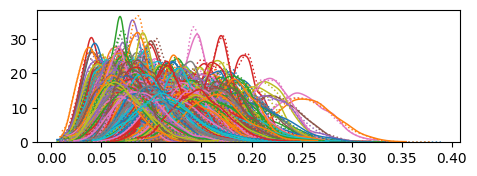

In [44]:
pm.plot_trace(idata_sccr)

In [43]:
pm.rhat(idata_sccr)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 0.9997 1.0 1.0 ... 1.002 1.002 1.001
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.007 1.001 1.0
    ν        float64 8B 1.001
    ν_p      (pos) float64 24B 1.005 1.005 1.007

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

I could not process the trace of the hierarchal data without goalkeepers so it is harder for pymc to process.

you lose more data from more players but you gain better results since data without goalkeepers gets rid out outiers since it is very rare for goalkeepers to score.